## CAPP 30254 - Homework 3
#### Alec MacMillen
#### Due 5/2/2019

The purpose of this homework is to predict predict whether a project on donorschoose will not get fully funded within 60 days of posting.

In [1]:
import pipeline as ppl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn import linear_model, metrics, preprocessing
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 200
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
donors = ppl.load_data("projects_2012_2013.csv")
donors = donors.rename(columns={'total_price_including_optional_support':'total_price'})
meta = ppl.generate_metadata(donors)
summary = ppl.generate_summary(donors)
print("There are", len(donors), "observations of", len(donors.columns), "variables:")
print(meta)
print("-----------------------------------------------------------------------------")
print(summary)

There are 124976 observations of 26 variables:
                              colname                     type  pct_null
0                           projectid            <class 'str'>  0.000000
1                      teacher_acctid            <class 'str'>  0.000000
2                            schoolid            <class 'str'>  0.000000
3                       school_ncesid  <class 'numpy.float64'>  0.073878
4                     school_latitude  <class 'numpy.float64'>  0.000000
5                    school_longitude  <class 'numpy.float64'>  0.000000
6                         school_city            <class 'str'>  0.000000
7                        school_state            <class 'str'>  0.000000
8                        school_metro            <class 'str'>  0.121815
9                     school_district            <class 'str'>  0.001376
10                      school_county            <class 'str'>  0.000000
11                     school_charter            <class 'str'>  0.000000
12  

Let's get some frequency counts of important variables.

In [3]:
for var in ['school_charter', 'school_magnet', 'primary_focus_subject', 'primary_focus_area', 'resource_type', 
            'poverty_level', 'grade_level', 'eligible_double_your_impact_match']:
    print('Frequency counts of', var, ':')
    print(donors[var].value_counts())
    print("-------------------------------")

Frequency counts of school_charter :
f    113340
t     11636
Name: school_charter, dtype: int64
-------------------------------
Frequency counts of school_magnet :
f    114273
t     10703
Name: school_magnet, dtype: int64
-------------------------------
Frequency counts of primary_focus_subject :
Literacy                 37408
Mathematics              16859
Literature & Writing     16141
Special Needs             8348
Visual Arts               5870
Applied Sciences          5825
Environmental Science     4835
Health & Life Science     4185
Music                     3931
History & Geography       2701
Early Development         2618
Character Education       2249
Other                     1809
Performing Arts           1682
ESL                       1604
Social Sciences           1538
Health & Wellness         1450
Gym & Fitness             1281
College & Career Prep     1217
Foreign Languages          898
Sports                     574
Economics                  491
Extracurricular     

These categorical variables are solid candidates for features. *primary_focus_subject* appears to be a more granular category of *primary_focus_area*, so the "area" variable would probably be a more generalizable/flexible feature to use. Let's also do some basic visualization of variable distributions.

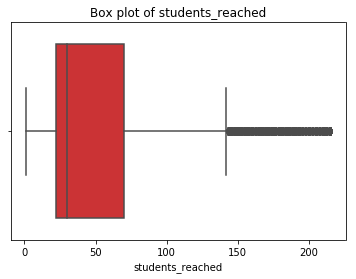

In [4]:
ppl.generate_boxplot(donors, 'students_reached')

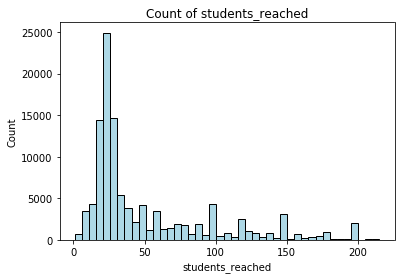

In [5]:
ppl.generate_histogram(donors, 'students_reached', 'lightblue', 5, 'Count of students_reached')

The distribution of *students_reached* has a long right tail, which indicates that we might want to bin the variable more tightly for lower values (say, buckets of 10 up to 50) and then expand bucket size to 50 up until the maximum count of students.

In [6]:
donors['teacher_prefix'].value_counts()

Mrs.    60190
Ms.     48511
Mr.     16273
Dr.         2
Name: teacher_prefix, dtype: int64

It might also be worth exploring whether the teacher's gender has any impact on whether the project gets funded. We would hope this wouldn't be the case, but the potential exists.

In [7]:
price_by_poverty = donors[['poverty_level', 'total_price']]
print("Mean price of project by poverty level")
print(price_by_poverty.groupby(['poverty_level']).mean())
print("-------------------------------------------")
print("Median price of project by poverty level")
print(price_by_poverty.groupby(['poverty_level']).median())
print("-------------------------------------------")

Mean price of project by poverty level
                  total_price
poverty_level                
high poverty       645.553708
highest poverty    638.461452
low poverty        767.358096
moderate poverty   701.941162
-------------------------------------------
Median price of project by poverty level
                  total_price
poverty_level                
high poverty           509.38
highest poverty        505.01
low poverty            570.11
moderate poverty       527.05
-------------------------------------------


Interestingly, the mean *total_price* of a posted project correlates inversely with *poverty_level*: projects in *low_poverty* areas tend to cost over 100 dollars more in *low_poverty* areas as compared to *high_poverty* and *highest_poverty* areas. This effect is somewhat attenuated but still present when looking at the median *total_price*: the median project in *low_poverty* areas is about 65 dollars more expensive than projects in *highest_poverty* areas.

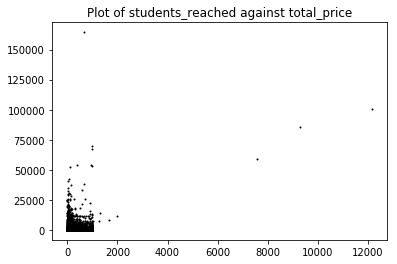

In [8]:
ppl.plot_scatter(donors, 'students_reached', 'total_price', outliers=True)

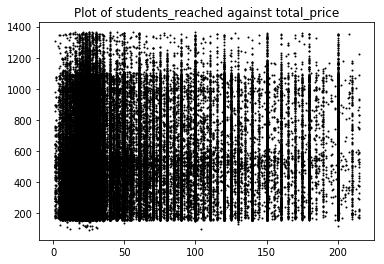

In [9]:
ppl.plot_scatter(donors, 'students_reached', 'total_price', outliers=False)

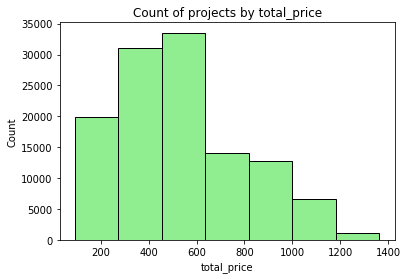

In [10]:
ppl.generate_histogram(donors, 'total_price', 'lightgreen', 200, 'Count of projects by total_price')

There are a few outliers on both the *students_reached* and *total_price* dimensions. Our discretization buckets probably shouldn't go any higher than 1500 for *total_price* or 50 for *students_reached* (before bucket widths expand from a few hundred dollars for *total_price* and 10 or so students for *students_reached*).

The next step is going to be to fill in NA values to fields to be used as features (except for *primary_focus_area* and *resource_type*, because there's no way to "guess" what omitted values of this variable should be classified as - we'll just drop them from the dataset). Then we'll discretize *total_price* and *students_reached*, and to create an indicator variable that takes a value of 1 if a project is fully funded within 60 days of posting and a 0 if not. This variable will be our target.

In [3]:
donors['school_charter'] = np.where(donors['school_charter'] == 't', 1, 0)
donors['school_magnet'] = np.where(donors['school_magnet'] == 't', 1, 0)
donors['eligible_double_your_impact_match'] = np.where(donors['eligible_double_your_impact_match'] == 't', 1, 0)

donors = donors[donors['primary_focus_area'] != np.NaN]
donors = donors[donors['resource_type'] != np.NaN]
donors = ppl.fill_na_values(donors, 'students_reached')

donors['datefullyfunded'] = pd.to_datetime(donors['datefullyfunded'])
donors['date_posted'] = pd.to_datetime(donors['date_posted'])
donors['timedelta'] = (donors['datefullyfunded'] - donors['date_posted']).dt.days
donors['not_funded_within_60_days'] = np.where(donors['timedelta'] > 60, 1, 0)

In [4]:
for col in ['students_reached', 'total_price']:
    donors[col] = preprocessing.scale(donors[col])
    quantiles = donors[col].quantile([0.0,0.25,0.5,0.75,1.00])
    bins = [quantiles[0.00], quantiles[0.25], quantiles[0.50], quantiles[0.75], quantiles[1.00]]
    labels = ['1','2','3','4']
    donors = ppl.discretize_continuous(donors, col, bins, labels)

Our target variable, *not_funded_within_60_days*, takes a value of 1 if the project has not been fully funded within 60 days of its posting date. These are the projects we may want to intervene with.

The first thing I want to do is train decision tree classifiers with different limiting values of *max_depth* to investigate whether there is a group of features that stand out as being the most important for high-level classisfication.

In [13]:
donors.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level', 'total_price',
       'students_reached', 'eligible_double_your_impact_match', 'date_posted',
       'datefullyfunded', 'timedelta', 'not_funded_within_60_days',
       'students_reached_cat', 'total_price_cat'],
      dtype='object')

In [5]:
x = donors[['school_charter', 'school_magnet', 'primary_focus_area', 'resource_type',
            'poverty_level', 'grade_level', 'total_price_cat', 'students_reached_cat',
            'eligible_double_your_impact_match']]
x_dummy = ppl.dummify_categorical(x, ['school_charter', 'school_magnet', 'primary_focus_area', 'resource_type',
            'poverty_level', 'grade_level', 'total_price_cat', 'students_reached_cat',
            'eligible_double_your_impact_match'])

y = donors[['not_funded_within_60_days']]

In [15]:
for depth in range(1,6):
    dtree = ppl.train_decision_tree(x_dummy, y, max_depth=depth)
    x_dummy.columns
    d = {'Features':x_dummy.columns, "Importance":dtree.feature_importances_}
    feature_importance = pd.DataFrame(data=d)
    feature_importance = feature_importance.sort_values(by=['Importance'], ascending=False)
    feature_importance = feature_importance[feature_importance['Importance'] > 0.0]
    print("Feature importance for decision tree with max_depth", depth, ":\n")
    print(feature_importance)
    print("--------------------------------------------------------")

Feature importance for decision tree with max_depth 1 :

             Features  Importance
22  total_price_cat_4         1.0
--------------------------------------------------------
Feature importance for decision tree with max_depth 2 :

                             Features  Importance
22                  total_price_cat_4    0.619134
21                  total_price_cat_3    0.335437
2   eligible_double_your_impact_match    0.045429
--------------------------------------------------------
Feature importance for decision tree with max_depth 3 :

                                  Features  Importance
22                       total_price_cat_4    0.466942
21                       total_price_cat_3    0.252982
20                       total_price_cat_2    0.183013
2        eligible_double_your_impact_match    0.066313
6        primary_focus_area_Math & Science    0.023803
5   primary_focus_area_Literacy & Language    0.006948
--------------------------------------------------------
Featu

In [16]:
feature_importance_list = feature_importance['Features'].tolist()
feature_importance_list

['total_price_cat_4',
 'total_price_cat_3',
 'total_price_cat_2',
 'eligible_double_your_impact_match',
 'poverty_level_highest poverty',
 'primary_focus_area_Math & Science',
 'resource_type_Trips',
 'resource_type_Technology',
 'primary_focus_area_Literacy & Language',
 'students_reached_cat_4',
 'poverty_level_low poverty',
 'primary_focus_area_Special Needs',
 'grade_level_Grades 9-12']

Now *feature_list* contains a list of the top 18 most important features according to the decision tree with max_depth = 5. The list of the top 5-10 or so features appears static as the decision tree's depth grows from 1 to 5, so we can be reasonably confident that these are the top features we should be selecting from in model training.

For our next step, let's create the 3 sets of train-test data, based on 6-month rolling windows in the 24-month data we have available:
- **Set 1**: train 1/1/2012-6/30/2012; test 7/1/2012-12/31/2012
- **Set 2**: train 1/1/2012-12/31/2012; test 1/1/2013-6/30/2013
- **Set 3**: train 1/1/2012-6/30/2013; test 7/1/2013-12/31/2013

In [6]:
starting_features = ['school_charter', 'school_magnet', 'primary_focus_area', 'resource_type',
                     'poverty_level', 'grade_level', 'total_price_cat', 'students_reached_cat',
                     'eligible_double_your_impact_match']

x_train1, x_test1, y_train1, y_test1 = ppl.create_date_splits(
    donors, starting_features, 'not_funded_within_60_days', 'date_posted', 
    ('01/01/2012', '06/30/2012'), ('07/01/2012', '12/31/2012'))
x_train1 = ppl.dummify_categorical(x_train1, starting_features)
x_test1 = ppl.dummify_categorical(x_test1, starting_features)

x_train2, x_test2, y_train2, y_test2 = ppl.create_date_splits(
    donors, starting_features, 'not_funded_within_60_days', 'date_posted', 
    ('01/01/2012', '12/31/2012'), ('01/01/2013', '06/30/2013'))
x_train2 = ppl.dummify_categorical(x_train2, starting_features)
x_test2 = ppl.dummify_categorical(x_test2, starting_features)

x_train3, x_test3, y_train3, y_test3 = ppl.create_date_splits(
    donors, starting_features, 'not_funded_within_60_days', 'date_posted', 
    ('01/01/2012', '06/30/2013'), ('07/01/2013', '12/31/2013'))
x_train3 = ppl.dummify_categorical(x_train3, starting_features)
x_test3 = ppl.dummify_categorical(x_test3, starting_features)

In [18]:
thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]

Because testing/validating a k-nearest-neighbors model is expensive, we will use only the top 5 most important features to get a sense of the best model specifications.

In [14]:
knn_summary_1 = ppl.knn_loop(x_train1[feature_importance_list[:5]], y_train1, x_test1[feature_importance_list[:5]], y_test1,
                             '01/01/2012-06/30/2012', '07/01/2012-12/31/2012', [10,30,50], ['euclidean'], 
                             ['uniform'], thresholds)

knn_summary_2 = ppl.knn_loop(x_train2[feature_importance_list[:5]], y_train2, x_test2[feature_importance_list[:5]], y_test2,
                             '01/01/2012-12/31/2012', '01/01/2013-06/30/2013', [10,30,50], ['euclidean'], 
                             ['uniform'], thresholds)

knn_summary_3 = ppl.knn_loop(x_train1[feature_importance_list[:5]], y_train1, x_test1[feature_importance_list[:5]], y_test1,
                             '01/01/2012-06/30/2013', '07/01/2013-12/31/2013', [10,30,50], ['euclidean'], 
                             ['uniform'], thresholds)

all_knn = pd.concat([knn_summary_1, knn_summary_2, knn_summary_3])
all_knn = all_knn.sort_values(by='auc', axis=0, ascending=False)
top_knn = all_knn[:10]

On the other hand, logistic regression trains and tests relatively quickly, so we can use *all* available features and include a broader range of hyperparameter combinations.

In [15]:
logistic_summary_1 = ppl.logistic_loop(x_train1, y_train1, x_test1, y_test1, '01/01/2012-06/30/2012', '07/01/2012-12/31/2012', 
                                       ['l1', 'l2'], [1.0, 0.75, 0.5], thresholds)

logistic_summary_2 = ppl.logistic_loop(x_train2, y_train2, x_test2, y_test2, '01/01/2012-12/31/2012', '01/01/2013-06/30/2013', 
                                       ['l1', 'l2'], [1.0, 0.75, 0.5], thresholds)

logistic_summary_3 = ppl.logistic_loop(x_train3, y_train3, x_test3, y_test3, '01/01/2012-06/30/2013', '07/01/2013-12/31/2013', 
                                       ['l1', 'l2'], [1.0, 0.75, 0.5], thresholds)

all_logistic = pd.concat([logistic_summary_1, logistic_summary_2, logistic_summary_3])
all_logistic = all_logistic.sort_values(by='auc', axis=0, ascending=False)
top_logistic = all_logistic[:10]

Decision trees are also relatively quick to train and test, so we will use all available features and a broader combination of hyperparameters.

In [16]:
dtree_summary_1 = ppl.decision_tree_loop(x_train1, y_train1, x_test1, y_test1, '01/01/2012-06/30/2012', '07/01/2012-12/31/2012', 
                                         ['gini','entropy'], ['best','random'], [1,2,3,5,10,None], thresholds)

dtree_summary_2 = ppl.decision_tree_loop(x_train2, y_train2, x_test2, y_test2, '01/01/2012-12/31/2012', '01/01/2013-06/30/2013', 
                                         ['gini','entropy'], ['best','random'], [1,2,3,5,10,None], thresholds)

dtree_summary_3 = ppl.decision_tree_loop(x_train3, y_train3, x_test3, y_test3, '01/01/2012-06/30/2013', '07/01/2013-12/31/2013', 
                                         ['gini','entropy'], ['best','random'], [1,2,3,5,10,None], thresholds)

all_dtree = pd.concat([dtree_summary_1, dtree_summary_2, dtree_summary_3])
all_dtree = all_dtree.sort_values(by='auc', axis=0, ascending=False)
top_dtree = all_dtree[:10]

Support vector machines (SVMs) also take a long time to train and validate, so we'll focus on the default values of parameters. Also, we've identified 0.3 as the threshold that appears most commonly in the best-performing models of other types, so we'll focus on that as a parameter in this case. These calls to the svm_loop from the pipeline module are easily extensible to other parameters and threshold levels.

In [ ]:
svm_summary_1 = ppl.svm_loop(x_train1[feature_importance_list[:5]], y_train1, x_test1[feature_importance_list[:5]], y_test1,
                             '01/01/2012-06/30/2012', '07/01/2012-12/31/2012', [1.0], ['rbf'], [3], [0.3])

svm_summary_2 = ppl.svm_loop(x_train2[feature_importance_list[:5]], y_train2, x_test2[feature_importance_list[:5]], y_test2,
                             '01/01/2012-12/31/2012', '01/01/2013-06/30/2013', [1.0], ['rbf'], [3], [0.3])

svm_summary_3 = ppl.svm_loop(x_train3[feature_importance_list[:5]], y_train3, x_test3[feature_importance_list[:5]], y_test3,
                             '01/01/2012-06/30/2013', '07/01/2013-12/31/2013', [1.0], ['rbf'], [3], [0.3])

all_svm = pd.concat([svm_summary_1, svm_summary_2, svm_summary_3])
all_svm = all_svm.sort_values(by='auc', axis=0, ascending=False)
top_svm = all_svm[:10]

For Random Forests, we will focus on the list of "most important" parameters.

In [20]:
rf_summary_1 = ppl.forest_loop(x_train1[feature_importance_list], y_train1, x_test1[feature_importance_list], y_test1,
                                        '01/01/2012-06/30/2012', '07/01/2012-12/31/2012', [10,50,100], ['gini'], [2,5,10,None], thresholds)

rf_summary_2 = ppl.forest_loop(x_train2[feature_importance_list], y_train2, x_test2[feature_importance_list], y_test2,
                                        '01/01/2012-12/31/2012', '01/01/2013-06/30/2013', [10,50,100], ['gini'], [2,5,10,None], thresholds)

rf_summary_3 = ppl.forest_loop(x_train3[feature_importance_list], y_train3, x_test3[feature_importance_list], y_test3,
                                        '01/01/2012-06/30/2013', '07/01/2013-12/31/2013', [10,50,100], ['gini'], [2,5,10,None], thresholds)

all_rf = pd.concat([rf_summary_1, rf_summary_2, rf_summary_3])
all_rf = all_rf.sort_values(by='auc', axis=0, ascending=False)
top_rf = all_rf[:10]

For our bagging model, we will use logistic regression as the base estimator, and focus on the "most important" features once again.

In [22]:
bagging_summary_1 = ppl.bagging_loop(x_train1[feature_importance_list], y_train1, x_test1[feature_importance_list], y_test1,
                                    '01/01/2012-06/30/2012', '07/01/2012-12/31/2012', [linear_model.LogisticRegression()], [10,50], [0.3])

bagging_summary_2 = ppl.bagging_loop(x_train2[feature_importance_list], y_train2, x_test2[feature_importance_list], y_test2,
                                    '01/01/2012-12/31/2012', '01/01/2013-06/30/2013', [linear_model.LogisticRegression()], [10,50], [0.3])

bagging_summary_3 = ppl.bagging_loop(x_train3[feature_importance_list], y_train3, x_test3[feature_importance_list], y_test3,
                                    '01/01/2012-06/30/2013', '07/01/2013-12/31/2013', [linear_model.LogisticRegression()], [10,50], [0.3])

all_bagging = pd.concat([bagging_summary_1, bagging_summary_2, bagging_summary_3])
all_bagging = all_bagging.sort_values(by='auc', axis=0, ascending=False)
top_bagging = all_bagging[:10]

The boosting model will also focus on the full subset of identified "most important" features.

In [25]:
boosting_summary_1 = ppl.boosting_loop(x_train1[feature_importance_list], y_train1, x_test1[feature_importance_list], y_test1,
                                      '01/01/2012-06/30/2012', '07/01/2012-12/31/2012', ['deviance'], [0.1], [10], [None], [0.3])

boosting_summary_2 = ppl.boosting_loop(x_train2[feature_importance_list], y_train2, x_test2[feature_importance_list], y_test2,
                                      '01/01/2012-12/31/2012', '01/01/2013-06/30/2013', ['deviance'], [0.1], [10], [None], [0.3])

boosting_summary_3 = ppl.boosting_loop(x_train3[feature_importance_list], y_train3, x_test3[feature_importance_list], y_test3,
                                      '01/01/2012-06/30/2013', '07/01/2013-12/31/2013', ['deviance'], [0.1], [10], [None], [0.3])

all_boosting = pd.concat([boosting_summary_1, boosting_summary_2, boosting_summary_3])
all_boosting = all_boosting.sort_values(by='auc', axis=0, ascending=False)
top_boosting = all_boosting[:10]

### Visualizing Model Results
#### Decision tree

Normalized confusion matrix
[[ 0.59646987  0.40353013]
 [ 0.34230656  0.65769344]]


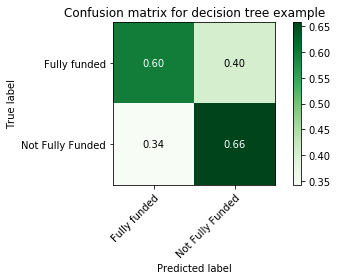

In [7]:
tree_1 = ppl.train_decision_tree(x_train2, y_train2, criterion='gini',
                                splitter='random', max_depth=5)
pred_scores = tree_1.predict_proba(x_test2)
pred_labels = [1 if x[1] > 0.3 else 0 for x in pred_scores]
ppl.plot_confusion_matrix(y_test2, pred_labels, ['Fully funded','Not Fully Funded'],
                         normalize=True, title="Confusion matrix for decision tree example")

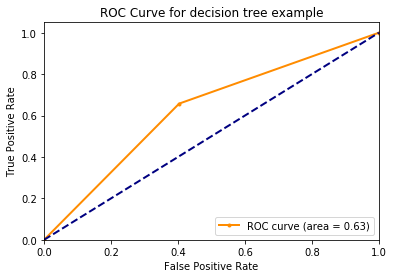

In [8]:
fpr, tpr, roc_auc = ppl.calculate_roc_curve(tree_1, x_test2, y_test2, 0.3)
ppl.plot_roc_curve(fpr, tpr, roc_auc, 'darkorange', 'ROC Curve for decision tree example')

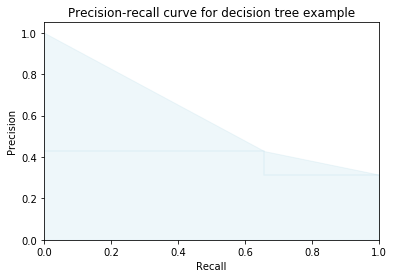

In [9]:
precision, recall, _ = metrics.precision_recall_curve(y_test2, pred_labels)
plt.step(recall, precision, color='lightblue', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='lightblue')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-recall curve for decision tree example")
plt.show()

#### Logistic regression

Normalized confusion matrix
[[ 0.60039224  0.39960776]
 [ 0.35010297  0.64989703]]


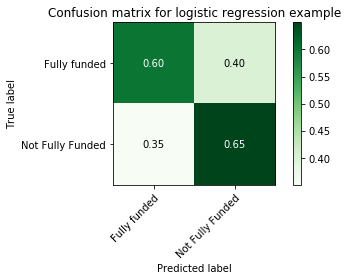

In [10]:
lr_1 = ppl.train_logistic(x_train2, y_train2)
pred_scores = lr_1.predict_proba(x_test2)
pred_labels = [1 if x[1] > 0.3 else 0 for x in pred_scores]
ppl.plot_confusion_matrix(y_test2, pred_labels, ['Fully funded','Not Fully Funded'],
                         normalize=True, title="Confusion matrix for logistic regression example")

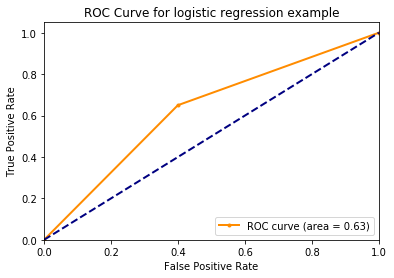

In [11]:
fpr, tpr, roc_auc = ppl.calculate_roc_curve(lr_1, x_test2, y_test2, 0.3)
ppl.plot_roc_curve(fpr, tpr, roc_auc, 'darkorange', 'ROC Curve for logistic regression example')

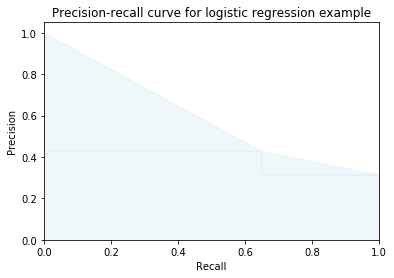

In [12]:
precision, recall, _ = metrics.precision_recall_curve(y_test2, pred_labels)
plt.step(recall, precision, color='lightblue', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='lightblue')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-recall curve for logistic regression example")
plt.show()